# Airy Disk with simple fluctuations

- 円形開口の平面波を作り (pupa)-> ガウシアン場（位相のみ）をかませ(pupa -> pupa) -> コロナグラフ関数としてFTだけするもの（No coronagraph function）を適用 -> 焦点面を算出(foca)するコード。すなわちゆがんだAiry Diskが出てくる

In [152]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('./../src/')

In [154]:
#from vcr/src
import plain_wave as pw
import mask_circular as mc
import no_coronagraph as nc
import pupil_grand as pg

## 星からの光を作る
星や惑星からの光は、位相のついた平面波で表される。いま微妙にoff axisを考えてみよう。

In [155]:
n=256 # sampling rate at a pupil
pos_star=[0.5,1.0] #angle in unit of lambda/D
pupa = pw.wg_plain_wave(n,pos_star)

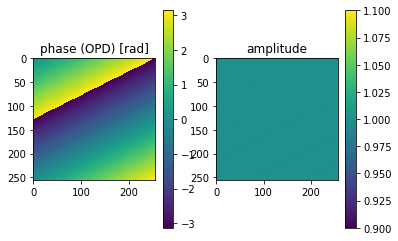

In [156]:
fig = plt.figure()
ax = fig.add_subplot(121)
q=ax.imshow(np.angle(pupa))
plt.title("phase (OPD) [rad]")
plt.colorbar(q)
ax = fig.add_subplot(122)
q=ax.imshow(np.abs(pupa))
plt.title("amplitude")
plt.colorbar(q)
plt.show()

## Gaussian Random Field

pupil_grand.pyでは以下のようにガウスランダム場を生成している
ガウシアンランダム場をつくるには,複素場の実部aと虚部bが
- $p(a) = \frac{1}{\sqrt{\pi f(k)}} \exp{\left( - \frac{a^2}{f(k)} \right) } d a $
- $p(b) = \frac{1}{\sqrt{\pi f(k)}} \exp{\left( - \frac{b^2}{f(k)} \right) } d b $

の分布関数に従う（つまりSTD が $\sigma = \sqrt{f(k)/2}$のガウシアン）$c = a + b i$を、フーリエ変換すれば良い。

もし作りたい場cが実数場の時には
- $a(k) = - a(k)$
- $b(k) = - b(-k)$
の条件を課す。実際には行列の半分+1列をReal IFFTにいれる。

In [157]:
var_field=(np.pi/4.0)*(np.pi/4.0) #位相乱れの分散
alpha=-3.0 #power
rmin=10.0 # softening radius in unit of pixel
pupa=pg.p2p_grand_phase_powerlaw(pupa,var_field=var_field,alpha=alpha,rmin=rmin)

[[ 0.+0.j  0.+0.j  0.+0.j ..., -0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...,  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j ...,  0.+0.j  0.+0.j -0.+0.j]
 ..., 
 [ 0.+0.j  0.+0.j  0.+0.j ...,  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ..., -0.+0.j  0.+0.j -0.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j ..., -0.+0.j  0.+0.j -0.+0.j]]

[[ 0.02863591-0.03243474j -0.05423957+0.02984081j -0.02896845-0.02960064j
  ..., -0.02093426+0.03436575j  0.03295570-0.01312962j
   0.03293403+0.0282485j ]
 [-0.00630912+0.02195014j  0.00131515-0.0158707j   0.03239586+0.03011645j
  ..., -0.00243049-0.05377062j  0.04250969+0.026466j
   0.04242120+0.07483937j]
 [-0.04849177-0.02576089j -0.04699284-0.00776969j -0.04002246-0.03295083j
  ...,  0.00688946+0.05172596j  0.05576579-0.04598883j
   0.02555745-0.01099947j]
 ..., 
 [-0.03086529-0.04748674j -0.03555117+0.02901121j -0.03287798+0.03661294j
  ..., -0.00622263-0.02550119j  0.04297613-0.00351603j
  -0.02262228+0.01706834j]
 [ 0.00414360+0.00748011j 

./../src/pupil_grand.py:40: RuntimeWarning: divide by zero encountered in power
  f[maskmax]=0.0


## 円形開口マスク
望遠鏡のマスクはpupil to pupilの関数である

In [158]:
pupa=mc.p2p_circular(pupa)

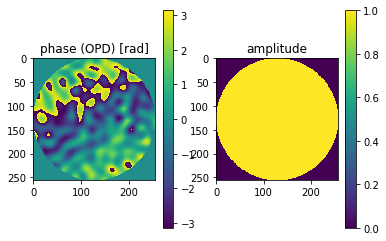

In [159]:
#表示

fig = plt.figure()
ax = fig.add_subplot(121)
q=ax.imshow(np.angle(pupa))
plt.title("phase (OPD) [rad]")
plt.colorbar(q)
ax = fig.add_subplot(122)
q=ax.imshow(np.abs(pupa))
plt.title("amplitude")
plt.colorbar(q)
plt.show()

## No coronagraph function = すなわち単にpupil -> focal plane をかけてみる。
- ここでのポイントは単に瞳での配列をFTすると焦点面での分解能は$\lambda/D$程度になってしまうため、コロナグラフ関数設計では、zero-paddingした拡大配列に入れてからFTをすることが基本となる。下のexpratは拡大率。

In [160]:
exprat=8 #oversampling factor at a focal plane
foca = nc.cf_no_coronagraph(pupa,exprat=exprat)

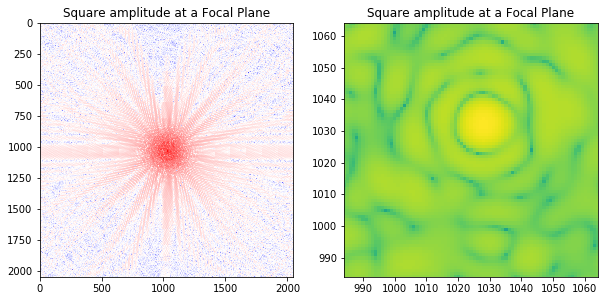

In [161]:
#表示
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(121)
a=ax.imshow(np.log10(np.abs(foca)**2),cmap="bwr")
#plt.colorbar(a)
plt.title("Square amplitude at a Focal Plane")
ax=fig.add_subplot(122)
a=ax.imshow(np.log10(np.abs(foca)**2))
#plt.colorbar(a)
nx=foca.shape[0]
ny=foca.shape[1]
plt.xlim(nx/2-5*exprat,nx/2+5*exprat)
plt.ylim(ny/2-5*exprat,ny/2+5*exprat)
plt.title("Square amplitude at a Focal Plane")
plt.show()

歪んだAiry diskが現われる